# Agents:
These simulations evaluate several agents exploring the thread the needle enviroment

In [84]:
%load_ext autoreload
%autoreload 2
# from IPython.display import display, HTML
# display(HTML("<style>.container { width:90% !important; }</style>"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [85]:
%matplotlib inline
import sys
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
import pickle
from stable_baselines3.common.monitor import Monitor, load_results
import networkx as nx

from task.gridworld import CnnWrapper, ThreadTheNeedleEnv
from utils.config_utils import parse_task_config, parse_model_config, load_config
from utils.pytorch_utils import DEVICE
from model.agents.value_iteration import ValueIterationAgent

from utils.pytorch_utils import (
    train_epochs,
    convert_float_to_8bit,
    make_tensor,
    convert_8bit_array_to_float_tensor,
    convert_8bit_to_float,
)

print(f"python {sys.version}")
print(f"torch {torch.__version__}")
print(f"device = {DEVICE}")


python 3.10.13 (main, Sep 11 2023, 08:16:02) [Clang 14.0.6 ]
torch 2.1.0.post100
device = mps


In [86]:
CONFIG_PATH = "configs"
TASK_CONFIG_FILE = "env_config.yml"
VAE_CONFIG_FILE = "vae_config.yml"
AGENT_CONFIG_FILE = "agent_config.yml"

TASK_NAME = "thread_the_needle"
MODEL_NAME = "cnn_vae"

# Create log dir
LOG_DIR = "tmp/"
os.makedirs(LOG_DIR, exist_ok=True)

TASK_CLASS = ThreadTheNeedleEnv
AgentClass = ValueIterationAgent

## Load Configs
task_config_file = os.path.join(CONFIG_PATH, TASK_CONFIG_FILE)
vae_config_file = os.path.join(CONFIG_PATH, VAE_CONFIG_FILE)
agent_config_file = os.path.join(CONFIG_PATH, AGENT_CONFIG_FILE)

env_kwargs = parse_task_config(TASK_NAME, task_config_file)
vae_config = parse_model_config(MODEL_NAME, vae_config_file)
agent_config = load_config(agent_config_file)

# create the task and get the optimal policy
task = CnnWrapper(TASK_CLASS.create_env(**env_kwargs))
pi, _ = task.get_optimal_policy()

SAVE_FILE_NAME = f"simulations/thread_the_needle_viagent_offline.csv"

  0%|          | 0/1000 [00:00<?, ?it/s]

In [87]:
# create the task and get the optimal policy
task = TASK_CLASS.create_env(**env_kwargs)
task = CnnWrapper(task)

# create the monitor
task = Monitor(task, LOG_DIR)

pi, _ = task.get_optimal_policy()
# training_kwargs["optimal_policy"] = pi

  0%|          | 0/1000 [00:00<?, ?it/s]

In [88]:
# load the rollouts and results from ppo
rollouts_file = 'simulations/ppo_rollouts.pkl'
ppo_performance_file = 'simulations/ppo_performance.pkl'

with open(rollouts_file, 'rb') as f:
    rollouts = pickle.load(f)

with open(ppo_performance_file, 'rb') as f:
    ppo_performance = pickle.load(f)



Text(0.5, 1.0, 'right')

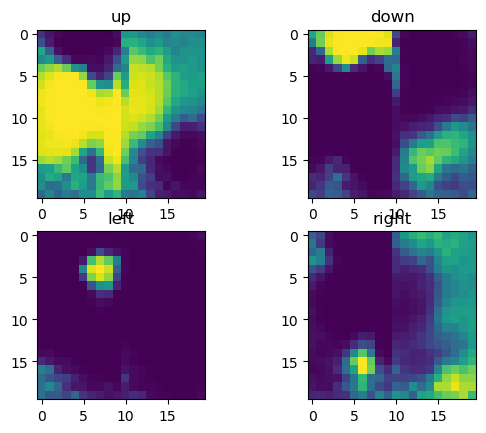

In [89]:
fig, axes = plt.subplots(2, 2)

pi_hat = ppo_performance["policy_pmf"]
h, w = env_kwargs["height"], env_kwargs["width"]
axes[0][0].imshow(pi_hat[:, 0].reshape(h, w))
axes[0][1].imshow(pi_hat[:, 1].reshape(h, w))
axes[1][0].imshow(pi_hat[:, 2].reshape(h, w))
axes[1][1].imshow(pi_hat[:, 3].reshape(h, w))


axes[0][0].set_title("up")
axes[0][1].set_title("down")
axes[1][0].set_title("left")
axes[1][1].set_title("right")

<BarContainer object of 4 artists>

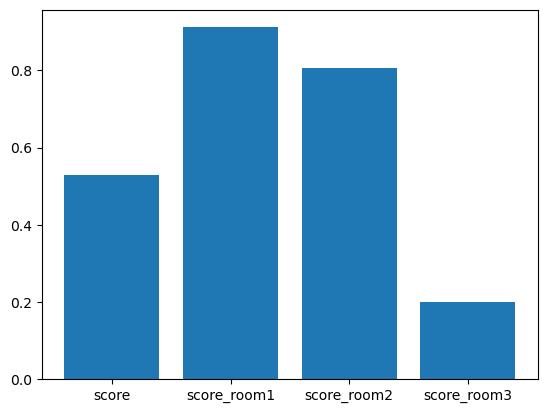

In [90]:
x = ['score', 'score_room1', 'score_room2', 'score_room3']
y = [ppo_performance[k] for k in x]
plt.bar(x, y)

In [91]:
### Model + Training Parameters

vae_config = parse_model_config(MODEL_NAME, vae_config_file)
agent_config = load_config(agent_config_file)


def make_model():
    agent = AgentClass.make_from_configs(task, agent_config, vae_config, env_kwargs)
    return agent


agent = make_model()
total_params = sum(p.numel() for p in agent.state_inference_model.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 2101681


In [92]:
agent = make_model()
agent.update_from_batch(rollouts, progress_bar=True)

Vae Epochs: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


In [113]:
np.argwhere(rollouts.get_dataset()['rewards'] > 0.0)

array([[803]])

In [93]:
Laplacian, state_key = agent.get_graph_laplacian()
Laplacian

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 3., 0., 0.],
       [0., 0., 0., ..., 0., 2., 0.],
       [0., 0., 0., ..., 0., 0., 2.]])

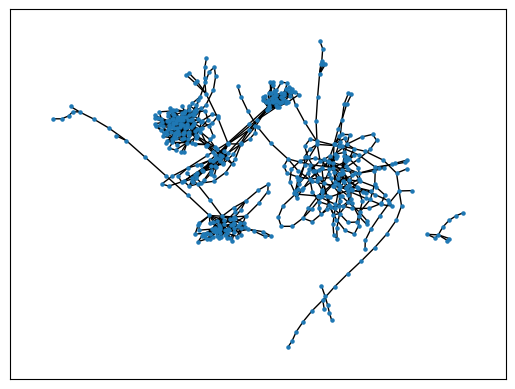

In [94]:
# convert the laplacian into a graph
edges = np.argwhere(Laplacian)
edges = [(i, j) for i, j in edges if i != j]  # remove self-edges

G = nx.Graph()
G.add_edges_from(edges)
nx.draw_networkx(G, with_labels=False, node_size=5)

In [95]:
agent.get_state_values()
node_values = {state_key[i]: v for i, v in agent.get_state_values().items()}

# normalize the node_vlaues
v_max = max([v for v in node_values.values()])
v_min = min([v for v in node_values.values()])
node_values = {k: (v - v_min) / (v_max - v_min) for k, v in node_values.items()}

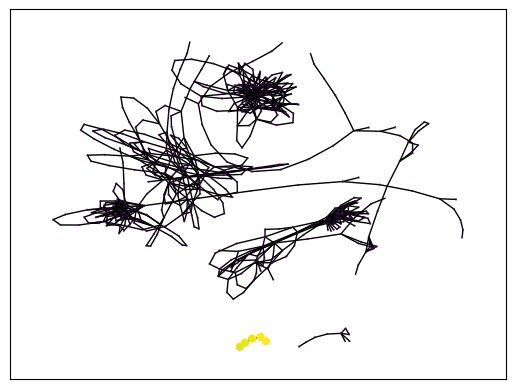

In [96]:
# convert the laplacian into a graph
edges = np.argwhere(Laplacian)
edges = [(i, j) for i, j in edges if i != j]  # remove self-edges

G = nx.Graph()
G.add_edges_from(edges)
color = [node_values.get(i, 0) for i in G.nodes]
size = [node_values.get(i, 0) * 25 for i in G.nodes]
nx.draw_networkx(G, with_labels=False, node_size=size, node_color=color, cmap="viridis")



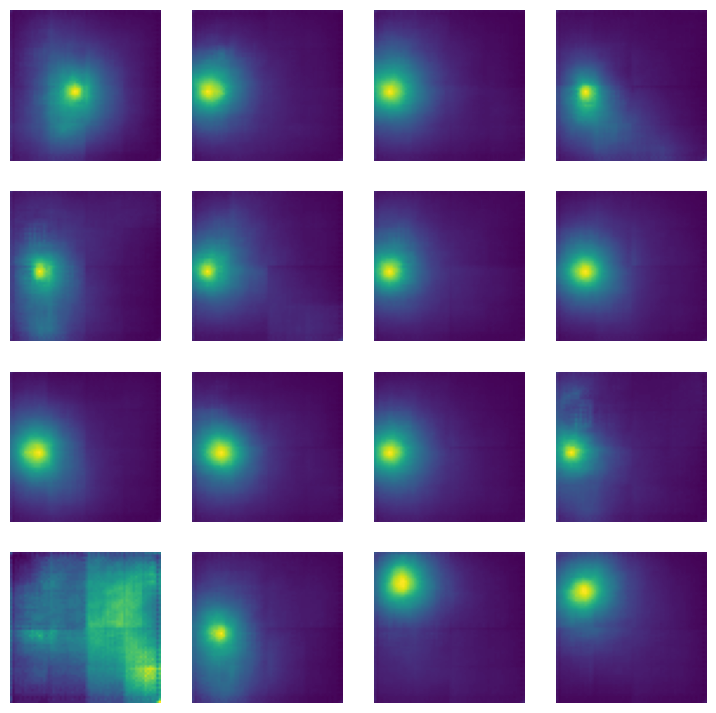

In [97]:
vae_model = agent.state_inference_model

import torch.nn.functional as F

# Sample generatively

z_layers = vae_config["vae_kwargs"]["z_layers"]
z_dim = vae_config["vae_kwargs"]["z_dim"]

N = 4


def sample_random_state():
    z = torch.randint(high=z_dim, size=tuple([z_layers]))
    return F.one_hot(z, num_classes=z_dim).to(DEVICE)


fig, axes = plt.subplots(N, N, figsize=(9, 9))

vae_model.eval()
for t in range(N**2):
    with torch.no_grad():
        z = sample_random_state()
    X_hat = vae_model.decode(z).detach().cpu()

    r, c = t // N, t % N
    plt.sca(axes[r][c])
    plt.imshow(convert_float_to_8bit(X_hat.squeeze()))
    plt.axis("off")

plt.show()

In [98]:
from utils.training_utils import get_policy_prob, vae_get_pmf

pmf = get_policy_prob(
    agent,
    vae_get_pmf,
    n_states=env_kwargs["n_states"],
    map_height=env_kwargs["map_height"],
    cnn=True,
)
pmf

ImportError: cannot import name 'get_policy_prob' from 'utils.training_utils' (/Users/nicholasfranklin/Projects/StateInference/utils/training_utils.py)

In [ ]:
plt.imshow(agent.rollout_buffer.get_tensor("obs").float().mean(dim=0).squeeze())

In [ ]:
sorted(list(agent.value_function.values()))

In [ ]:
import seaborn as sns

fig, axes = plt.subplots(2, 2)
h, w = env_kwargs["height"], env_kwargs["width"]

axes[0][0].imshow(pmf[:, 0].reshape(h, w))
axes[0][1].imshow(pmf[:, 1].reshape(h, w))
axes[1][0].imshow(pmf[:, 2].reshape(h, w))
axes[1][1].imshow(pmf[:, 3].reshape(h, w))


axes[0][0].set_title("up")
axes[0][1].set_title("down")
axes[1][0].set_title("left")
axes[1][1].set_title("right")

plt.subplots_adjust(hspace=0.3, wspace=-0.3)

plt.suptitle("Value Iteration Agent Learned Policy")

In [ ]:
np.sum(pi * pmf, axis=1).mean()

In [ ]:
room_1_mask = (np.arange(400) < 200) * (np.arange(400) % 20 < 10)
room_2_mask = (np.arange(400) >= 200) * (np.arange(400) % 20 < 10)
room_3_mask = np.arange(400) % 20 >= 10

score_room_1 = np.sum(pi[room_1_mask] * pmf[room_1_mask], axis=1).mean()
score_room_2 = np.sum(pi[room_2_mask] * pmf[room_2_mask], axis=1).mean()
score_room_3 = np.sum(pi[room_3_mask] * pmf[room_3_mask], axis=1).mean()
plt.bar([0, 1, 2], [score_room_1, score_room_2, score_room_3])

sns.despine()

In [ ]:
from utils.pytorch_utils import make_tensor, convert_8bit_to_float
from sklearn.metrics import pairwise_distances

obs = convert_8bit_to_float(
    torch.stack(
        [
            make_tensor(task.observation_model(s))
            for s in range(task.transition_model.n_states)
            for _ in range(1)
        ]
    )
)[:, None, ...].to(DEVICE)
z = agent.state_inference_model.get_state(obs)

hash_vector = np.array(
    [
        agent.state_inference_model.z_dim**ii
        for ii in range(agent.state_inference_model.z_layers)
    ]
)

z = z.dot(hash_vector)
d = pairwise_distances(z.reshape(-1, 1), metric=lambda x, y: x == y)
plt.imshow(1 - d)

In [ ]:
# plot the overlap of different states
# number the states and plot them
clusters = {}
k = 0
for z0 in sorted(z):
    if z0 not in clusters.keys():
        clusters[z0] = k
        k += 1
clustered_states = np.array([clusters[z0] for z0 in z])
plt.imshow(clustered_states.reshape(-1, 20))
task.display_gridworld(plt.gca(), wall_color="w")

In [ ]:
euc = pairwise_distances(
    [(x, y) for x in range(20) for y in range(20)],
    # metric=lambda x, y: np.sqrt((x[0] - y[0]) ** 2 + (x[1] - y[1]) ** 2),
    metric=lambda x, y: np.abs(x[0] - y[0]) + np.abs(x[1] - y[1]),
)

d_w_wall = np.mean([d[s1][s2] for s1, s2 in task.transition_model.walls])
print(f"Distance between neighboring states sepearted by a wall     {d_w_wall}")


wall_mask = np.zeros((task.n_states, task.n_states))
for s0, s1 in task.transition_model.walls:
    wall_mask[s0][s1] = 1.0
    wall_mask[s1][s0] = 1.0


d_wo_wall = d.reshape(-1)[(wall_mask.reshape(-1) == 0) & (euc.reshape(-1) == 1)].mean()
print(f"Distance between neighboring states NOT sepearted by a wall {d_wo_wall}")

In [ ]:
# agent._estimate_reward_model()

rews = np.array([agent.reward_estimator.get_avg_reward(z0) for z0 in z]).reshape(20, 20)
plt.imshow(rews)

In [ ]:
obs = convert_8bit_to_float(
    torch.stack(
        [
            make_tensor(task.observation_model(s))
            for s in range(task.transition_model.n_states)
            for _ in range(1)
        ]
    )
)[:, None, ...].to(DEVICE)
z = agent.state_inference_model.get_state(obs)

hash_vector = np.array(
    [
        agent.state_inference_model.z_dim**ii
        for ii in range(agent.state_inference_model.z_layers)
    ]
)

z = z.dot(hash_vector)

rews = np.array([agent.reward_estimator.get_avg_reward(z0) for z0 in z]).reshape(20, 20)
plt.imshow(rews)

In [ ]:
def get_value_function(model, task):
    obs = convert_8bit_to_float(
        torch.stack(
            [
                make_tensor(task.observation_model(s))
                for s in range(task.transition_model.n_states)
                for _ in range(1)
            ]
        )
    )[:, None, ...].to(DEVICE)
    z = model.state_inference_model.get_state(obs)

    hash_vector = np.array(
        [
            model.state_inference_model.z_dim**ii
            for ii in range(agent.state_inference_model.z_layers)
        ]
    )

    z = z.dot(hash_vector)

    value_function = np.array(
        [agent.value_function.get(z0, np.nan) for z0 in z]
    ).reshape(20, 20)
    return value_function


v = get_value_function(agent, task)
plt.imshow(v)
task.display_gridworld(plt.gca(), wall_color="w", annotate=True)
plt.title("Learned Value function")

In [ ]:
plt.plot(v[5] - np.nanmin(v))

In [ ]:
from tqdm import trange


## Repeat with iterations
n_models = 8
# n_models=4


room_1_mask = (np.arange(400) < 200) * (np.arange(400) % 20 < 10)
room_2_mask = (np.arange(400) >= 200) * (np.arange(400) % 20 < 10)
room_3_mask = np.arange(400) % 20 >= 10


scores = []
value_functions = []


for idx in trange(n_models):
    agent = make_model()
    agent.learn(total_timesteps=agent_config["n_train_steps"], progress_bar=False)
    #     agent.learn(total_timesteps=500, progress_bar=False)

    pmf = get_policy_prob(
        agent,
        vae_get_pmf,
        n_states=env_kwargs["n_states"],
        map_height=env_kwargs["map_height"],
        cnn=True,
    )

    score_room_1 = np.sum(pi[room_1_mask] * pmf[room_1_mask], axis=1).mean()
    score_room_2 = np.sum(pi[room_2_mask] * pmf[room_2_mask], axis=1).mean()
    score_room_3 = np.sum(pi[room_3_mask] * pmf[room_3_mask], axis=1).mean()

    v = get_value_function(agent, task)

    scores.append(
        pd.DataFrame(
            {
                "Iteration": [idx] * 4,
                "Score": [
                    np.sum(pi * pmf, axis=1).mean(),
                    score_room_1,
                    score_room_2,
                    score_room_3,
                ],
                "Condition": ["Overall", "Room 1", "Room 2", "Room 3"],
            }
        )
    )

    value_functions.append(
        pd.DataFrame(
            {
                "Iteration": [idx] * task.n_states,
                "State-Values": v.reshape(-1),
                "States": np.arange(task.n_states),
            }
        )
    )

scores = pd.concat(scores)
value_functions = pd.concat(value_functions)

In [ ]:
# Plot the average value function (n)

# normalize the value function between zero and one within each iteration
from sklearn.preprocessing import MinMaxScaler


def min_max_scale(grouped_data):
    v = grouped_data["State-Values"].values.reshape(-1, 1)
    v = MinMaxScaler().fit_transform(grouped_data["State-Values"].values.reshape(-1, 1))
    grouped_data["State-Values"] = v
    return grouped_data.drop("Iteration", axis=1)


normed_vf = value_functions.groupby("Iteration", group_keys=True).apply(min_max_scale)

# average and plot
plt.imshow(x.groupby("States").mean().values.reshape(20, 20))
task.display_gridworld(plt.gca(), wall_color="w", annotate=True)
plt.title("Learned Value function")

In [ ]:
# plot 1d Value function through the goal
normed_vf["Row"] = normed_vf["States"] // 20
normed_vf["Column"] = normed_vf["States"] % 20

sns.relplot(
    data=normed_vf[normed_vf["Row"] == 4], x="Column", y="State-Values", kind="line"
)
sns.relplot(
    data=normed_vf[(normed_vf["Column"] >= 9) & (normed_vf["Column"] <= 10)],
    x="Row",
    y="State-Values",
    kind="line",
    hue="Column",
)

plt.imshow(
    value_functions.groupby("States")["State-Values"]
    .apply(np.nanmean)
    .values.reshape(20, 20)
)
value_functions.to_csv('value_functions_vae.csv')

In [ ]:
sns.catplot(data=scores, y="Score", x="Condition", kind="bar")

In [ ]:
scores["Model"] = "Value Iteration"
scores.to_csv(SAVE_FILE_NAME)
scores2 = pd.read_csv("sims_thread_the_needle.csv")
scores2["Model"] = "PPO"
scores3 = pd.read_csv("sims_thread_the_needle_state_inf.csv")
scores3["Model"] = "Value Iteration + action based decoder"


all_scores = pd.concat([scores, scores2, scores3])
sns.catplot(
    data=all_scores[all_scores["Condition"] != "Overall"],
    y="Score",
    x="Condition",
    kind="point",
    hue="Model",
)
plt.gca().set_ylim([0, 1])

In [ ]:
sns.catplot(
    data=all_scores[all_scores["Condition"] == "Overall"],
    y="Score",
    x="Model",
    kind="bar",
)
plt.gca().set_ylim([0, 1])